# Computing energies using SMIRNOFFEE

This example will show how the energy of a water dimer (TIP4P-FB and TIP3P) in multiple conformations can be evaluated using `smirnoffee` framework. 

We start by creating the dimer topology and generating a set of conformers:

In [1]:
import openff.toolkit
import openff.units
import torch

water = openff.toolkit.Molecule.from_smiles("O")
water.generate_conformers(n_conformers=1)

water_conformer = torch.tensor(water.conformers[0].m_as(openff.units.unit.angstrom))

dimer = openff.toolkit.Topology()
dimer.add_molecule(water)
dimer.add_molecule(water)

conformers = torch.stack(
    [
        torch.vstack([water_conformer, water_conformer + torch.tensor(1.5 + i * 0.05)])
        for i in range(40)
    ]
)
conformers.shape

torch.Size([40, 6, 3])

For simplicity, we have created 40 dimer conformers, with a separation ranging from 1.5-3.5 Å by crudely shifting our initial conformer along the x-axis. 

**Note:** Conformers should either be tensor with a shape of `(n_atoms, 3)` or `(n_conformers, n_atoms, 3)`, and units of Å._

Next we will load in the force field that encodes the potential energy function we wish to evaluate and apply it to our molecule.

In [2]:
import openff.interchange

tip4p_force_field = openff.toolkit.ForceField("tip4p_fb.offxml")
tip4p_interchange = openff.interchange.Interchange.from_smirnoff(
    tip4p_force_field, dimer
)

In order to use an interchange object with this framework, we need to map it into a collection of tensors:

In [3]:
from smirnoffee.ff import convert_interchange

tip4p_tensor_ff, [tip4p_tensor_topology] = convert_interchange(tip4p_interchange)

**Note:** The `convert_interchange` function can take either a single interchange object, or a list of multiple.

These tensors are returned as:

* a `smirnoffee.ff.TensorForceField`: this stores the original values of the force field parameters in tensor form.
* a list of ``smirnoffee.ff.TensorTopology``: each 'topology' will store for each handler matrices defining which parameters were assigned to which elements (e.g. bonds, angles, torsions), as well as any virtual sites that were added.

Storing the raw parameter values separately from how they should be applied to molecules / topologies allows us to more easily modify their values, and then re-evaluate the energy.

In addition to storing force field parameters, these objects also describe which virtual sites (if any) should be present. We can use this information to update our initial conformers to have the relevant virtual sites:

In [4]:
from smirnoffee.geometry import add_v_site_coords

tip4p_conformers = add_v_site_coords(
    tip4p_tensor_topology.v_sites, conformers, tip4p_tensor_ff
)
tip4p_conformers.shape

torch.Size([40, 8, 3])

Here two the coordinates of the two virtual sites (i.e. one on each water molecule) have been appended to each of our 40 conformers.

The energy each dimer can then be directly be evaluated and plotted

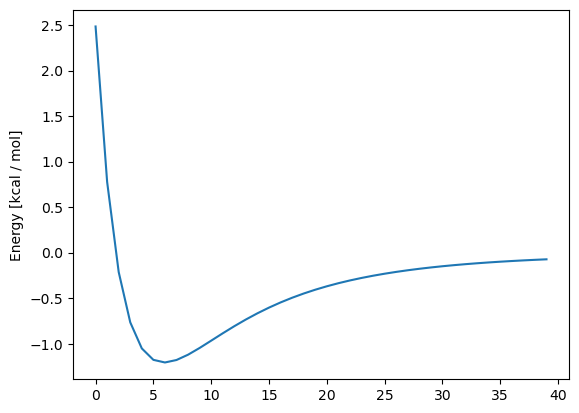

In [5]:
from smirnoffee.potentials import compute_energy

tip4p_energies = compute_energy(
    tip4p_tensor_topology.parameters, tip4p_conformers, tip4p_tensor_ff
)

from matplotlib import pyplot

pyplot.plot(tip4p_energies, label="tip4p")
pyplot.ylabel("Energy [kcal / mol]");

The above can easily be repeated using the TIP3P water model, allowing us to compare the dimer energy curves.

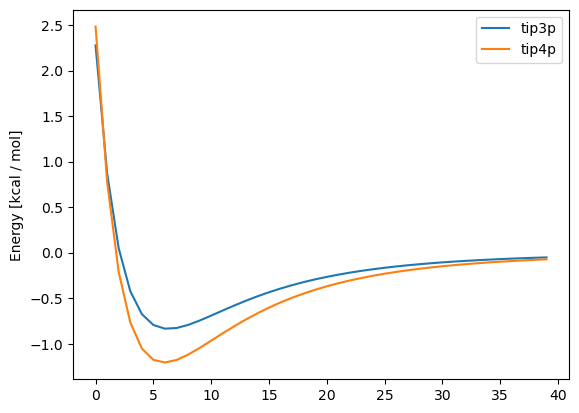

In [6]:
tip3p_force_field = openff.toolkit.ForceField("tip3p.offxml")
tip3p_interchange = openff.interchange.Interchange.from_smirnoff(
    tip3p_force_field, dimer
)

tip3p_tensor_ff, [tip3p_tensor_topology] = convert_interchange(tip3p_interchange)

tip3p_energies = compute_energy(
    tip3p_tensor_topology.parameters, conformers, tip3p_tensor_ff
)

pyplot.plot(tip3p_energies, label="tip3p")
pyplot.plot(tip4p_energies, label="tip4p")

pyplot.ylabel("Energy [kcal / mol]")
pyplot.legend();

A further advantage of storing our applied force field parameters in SMIRNOFFEE form is the ability to compute only the energy due to a particular handler (e.g. only LJ energies). 

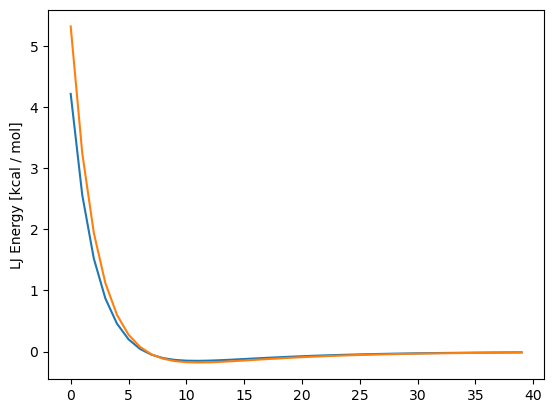

In [7]:
from smirnoffee.potentials import compute_energy_potential

tip3p_lj_energies = compute_energy_potential(
    tip3p_tensor_topology.parameters["vdW"],
    conformers,
    tip3p_tensor_ff.potentials_by_type["vdW"],
)
tip4p_lj_energies = compute_energy_potential(
    tip4p_tensor_topology.parameters["vdW"],
    tip4p_conformers,
    tip4p_tensor_ff.potentials_by_type["vdW"],
)

pyplot.plot(tip3p_lj_energies, label="tip3p")
pyplot.plot(tip4p_lj_energies, label="tip4p")

pyplot.ylabel("LJ Energy [kcal / mol]");